In [1]:
!pip3 install tensorflow-estimator==2.6.0

     |████████████████████████████████| 462 kB 4.6 MB/s            
  Attempting uninstall: tensorflow-estimator
    Found existing installation: tensorflow-estimator 2.7.0
    Uninstalling tensorflow-estimator-2.7.0:
      Successfully uninstalled tensorflow-estimator-2.7.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow-gpu 2.6.0 requires numpy~=1.19.2, but you have numpy 1.21.4 which is incompatible.
tensorflow-gpu 2.6.0 requires six~=1.15.0, but you have six 1.16.0 which is incompatible.
tensorflow-gpu 2.6.0 requires typing-extensions~=3.7.4, but you have typing-extensions 4.0.1 which is incompatible.


In [2]:
# Tensorflow와 Tensoflow Hub에 있는 이미 학습된 모델을 활용하기 위한 모듈 
import tensorflow as tf
import tensorflow_hub as hub

# 이미지를 다운로드하는 데에 사용하는 모듈
import matplotlib.pyplot as plt
import tempfile 
from six.moves.urllib.request import urlopen
from six import BytesIO

# 이미지에 선과 폰트를 넣기 위한 모듈
import numpy as np
from PIL import Image
from PIL import ImageColor
from PIL import ImageDraw
from PIL import ImageFont
from PIL import ImageOps

# Detection하는 데에 소요된 시간을 점검하기 위한 모듈
import time

In [3]:
def display_image(image):
  fig = plt.figure(figsize=(20, 15))
  plt.grid(False)
  plt.imshow(image)

In [4]:
def download_and_resize_image(url, new_width=256, new_height=256, display=False): 
  
  _, filename = tempfile.mkstemp(suffix=".jpg")
  response = urlopen(url)
  image_data = response.read()
  image_data = BytesIO(image_data)  # 이미지 읽기
  pil_image = Image.open(image_data)
  pil_image = ImageOps.fit(pil_image, (new_width, new_height), Image.ANTIALIAS) # 이미지 조정
  pil_image_rgb = pil_image.convert("RGB") #RBG로 변환
  pil_image_rgb.save(filename, format="JPEG", quality=90) # 이미지 저장
  print("Image downloaded to %s." % filename)
  if display:
    display_image(pil_image)
  return filename

In [5]:
def draw_bounding_box_on_image(image, 
                               ymin, xmin, ymax, xmax,
                               color,
                               font,
                               thickness=4,
                               display_str_list=()):
  
  draw = ImageDraw.Draw(image)
  im_width, im_height = image.size
  (left, right, top, bottom) = (xmin * im_width, xmax * im_width,
                                ymin * im_height, ymax * im_height)

# BBox 테두리 그리기
  draw.line([(left, top), (left, bottom), (right, bottom), (right, top),
             (left, top)],
            width=thickness,
            fill=color)

  display_str_heights = [font.getsize(ds)[1] for ds in display_str_list]
  
  total_display_str_height = (1 + 2 * 0.05) * sum(display_str_heights)

  if top > total_display_str_height:
    text_bottom = top
  else:
    text_bottom = top + total_display_str_height
  
  for display_str in display_str_list[::-1]:
    text_width, text_height = font.getsize(display_str)
    margin = np.ceil(0.05 * text_height)
    draw.rectangle([(left, text_bottom - text_height - 2 * margin),
                    (left + text_width, text_bottom)],
                   fill=color)
    draw.text((left + margin, text_bottom - text_height - margin),
              display_str,
              fill="black",
              font=font)
    text_bottom -= text_height - 2 * margin

In [6]:
# BBox 그리기
def draw_boxes(image, boxes, class_names, scores, max_boxes=10, min_score=0.1): 
  colors = list(ImageColor.colormap.values())

  try:
    font = ImageFont.truetype("/usr/share/fonts/truetype/liberation/LiberationSansNarrow-Regular.ttf",
                              25)
  except IOError:
    print("Font not found, using default font.")
    font = ImageFont.load_default()

# BBox 그리기 적용
  for i in range(min(boxes.shape[0], max_boxes)):
    if scores[i] >= min_score:
      ymin, xmin, ymax, xmax = tuple(boxes[i])  # 박스 좌표값
      display_str = "{}: {}%".format(class_names[i].decode("ascii"),
                                     int(100 * scores[i]))
      color = colors[hash(class_names[i]) % len(colors)]
      image_pil = Image.fromarray(np.uint8(image)).convert("RGB")
      draw_bounding_box_on_image(
          image_pil,
          ymin,
          xmin,
          ymax,
          xmax,
          color,
          font,
          display_str_list=[display_str])
      np.copyto(image, np.array(image_pil))
  return image

In [7]:
def load_img(path):
  img = tf.io.read_file(path)
  img = tf.image.decode_jpeg(img, channels=3)
  return img

In [8]:
def run_detector(detector, path):
  img = load_img(path) 

  converted_img  = tf.image.convert_image_dtype(img, tf.float32)[tf.newaxis, ...]

# 소요시간 측정
  start_time = time.time()
  result = detector(converted_img)
  end_time = time.time()

  result = {key:value.numpy() for key,value in result.items()}

# 이미지 추론 개수와 추론 시간 출력
  print("Found %d objects." % len(result["detection_scores"]))
  print("Inference time: ", end_time-start_time)

# 이미지 내 박스로 entity, scores를 추가하여 출력
  image_with_boxes = draw_boxes(
      img.numpy(), result["detection_boxes"],
      result["detection_class_entities"], result["detection_scores"])

  display_image(image_with_boxes)

Image downloaded to /tmp/tmp59bghzj0.jpg.


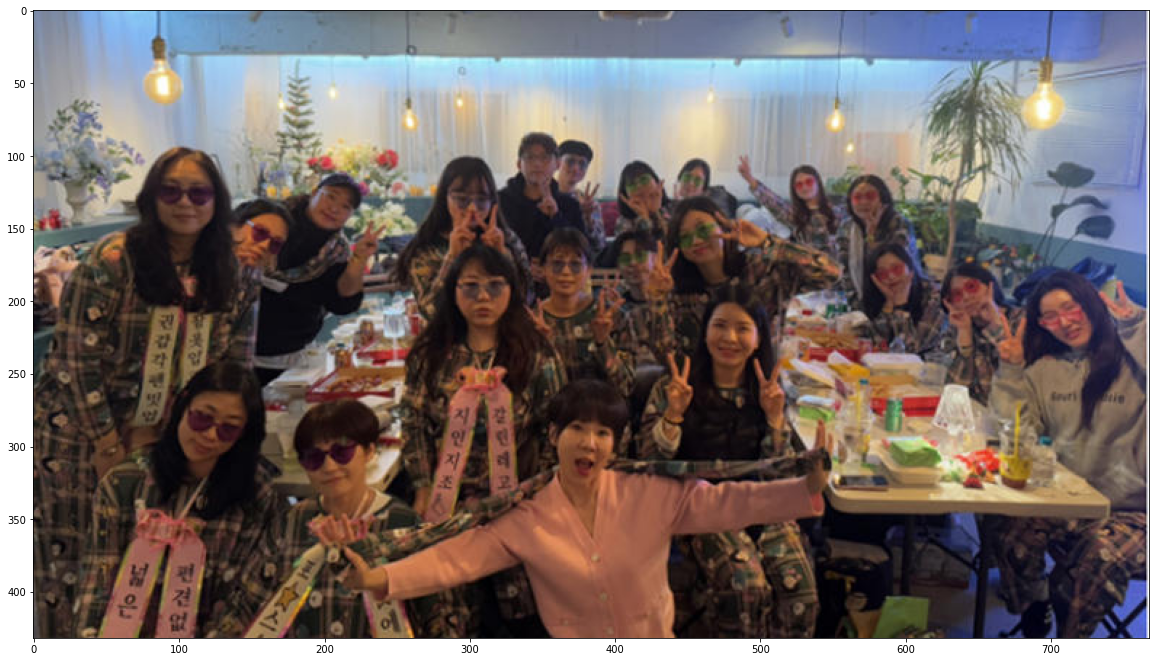

In [9]:
# 이미지 불러오기
image_url = "https://img-s-msn-com.akamaized.net/tenant/amp/entityid/BB1rl3ka.img?w=768&h=432&m=6&x=137&y=186&s=690&d=219"
downloaded_image_path = download_and_resize_image(image_url, 768, 432, True)  # new_width와 new_height를 변경해 보세요.

In [16]:
module_handle = "https://tfhub.dev/google/faster_rcnn/openimages_v4/inception_resnet_v2/1"  

detector = hub.load(module_handle).signatures['default'] # detector에 사용할 모듈 저장

INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


Found 100 objects.
Inference time:  0.1394820213317871


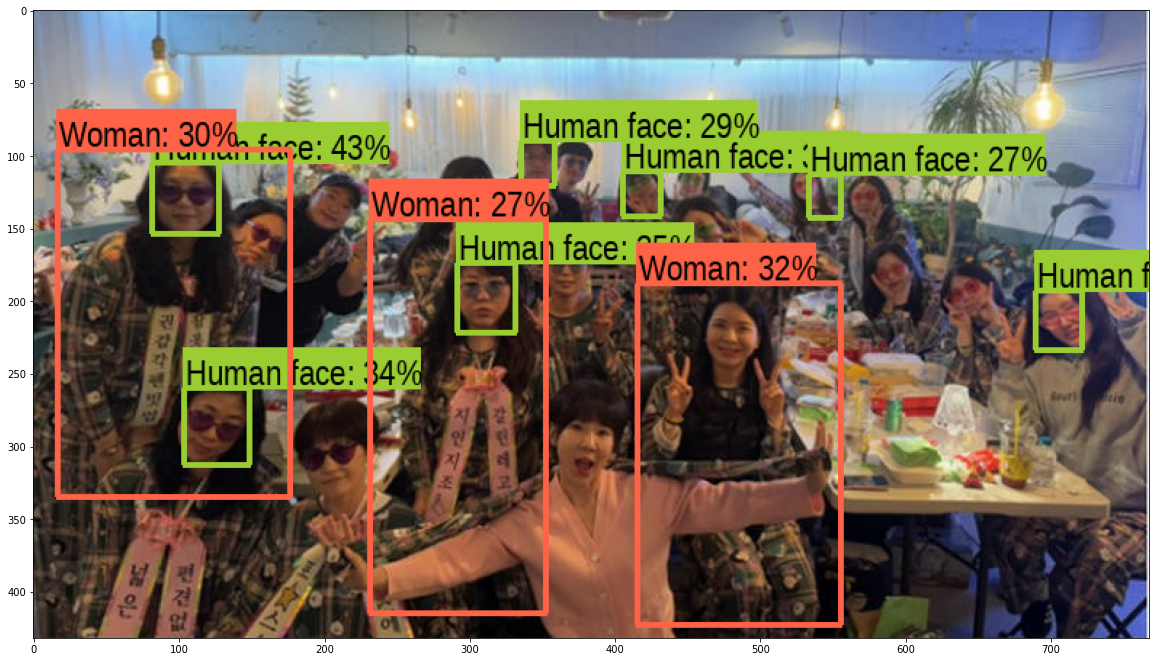

In [15]:
run_detector(detector, downloaded_image_path)

In [13]:
module_handle = "https://tfhub.dev/google/openimages_v4/ssd/mobilenet_v2/1"  

detector = hub.load(module_handle).signatures['default'] # detector에 사용할 모듈 저장

INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


Found 100 objects.
Inference time:  6.752749681472778


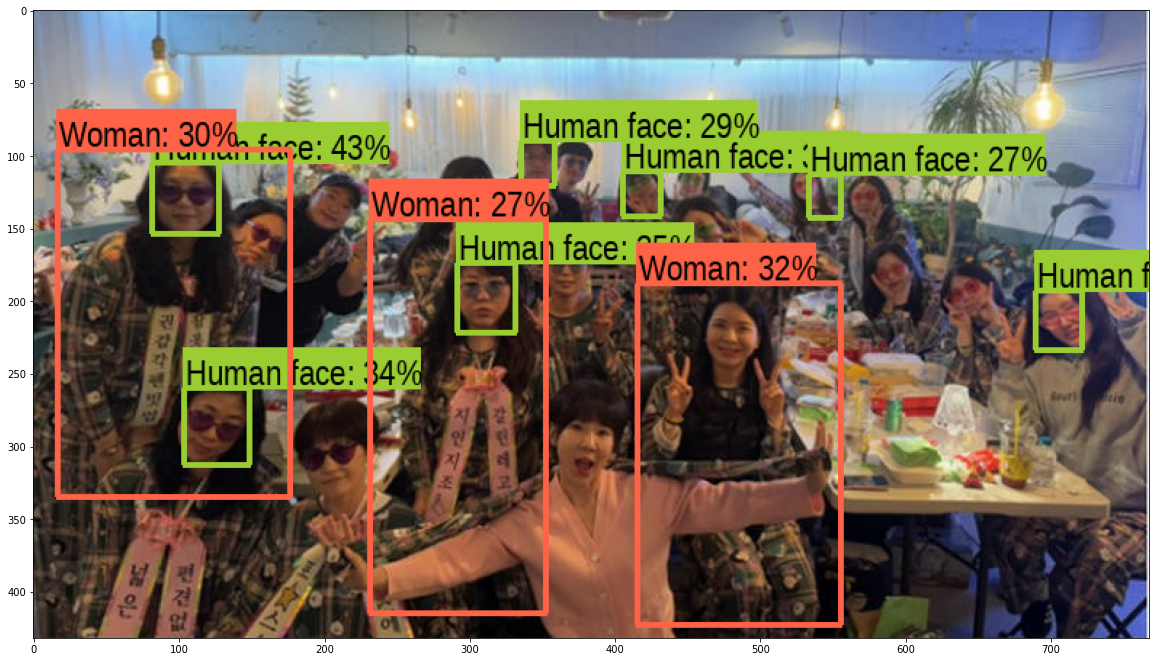

In [14]:
run_detector(detector, downloaded_image_path)

## 다른 모듈 적용해보기

In [5]:
# !pip install tensorflow tensorflow-hub matplotlib opencv-python
# !pip uninstall tensorflow tensorflow-hub matplotlib opencv-python -y
#여기때문에 쥬피터 노트북 환경이 망가짐

Found existing installation: tensorflow 2.18.0
Uninstalling tensorflow-2.18.0:
  Successfully uninstalled tensorflow-2.18.0
Found existing installation: tensorflow-hub 0.12.0
Uninstalling tensorflow-hub-0.12.0:
  Successfully uninstalled tensorflow-hub-0.12.0
Found existing installation: matplotlib 3.4.3
Uninstalling matplotlib-3.4.3:
  Successfully uninstalled matplotlib-3.4.3
Found existing installation: opencv-python 4.5.3.56
Uninstalling opencv-python-4.5.3.56:
  Successfully uninstalled opencv-python-4.5.3.56


In [ ]:
# 이미지 불러오기
image_url = "https://img-s-msn-com.akamaized.net/tenant/amp/entityid/BB1rl3ka.img?w=768&h=432&m=6&x=137&y=186&s=690&d=219"
downloaded_image_path = download_and_resize_image(image_url, 768, 432, True)  # new_width와 new_height를 변경해 보세요.

In [2]:
import tensorflow as tf
import tensorflow_hub as hub
import numpy as np
import cv2
import matplotlib.pyplot as plt

# EfficientDet D0 모델 로드
MODEL_URL = "https://tfhub.dev/tensorflow/efficientdet/d0/1"
detector = hub.load(MODEL_URL)

# 이미지 읽기 및 전처리
def load_image(path):
    img = cv2.imread(path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img_resized = tf.image.resize(img, (512, 512))  # EfficientDet D0의 입력 크기
    img_resized = img_resized / 255.0  # 정규화
    return img, tf.expand_dims(img_resized, axis=0)

# 감지 결과 시각화
def visualize_detections(image, detections):
    boxes = detections["detection_boxes"].numpy()
    class_ids = detections["detection_classes"].numpy().astype(int)
    scores = detections["detection_scores"].numpy()

    # COCO 데이터셋 클래스 이름 (부분 발췌)
    COCO_CLASSES = [
        "background", "person", "bicycle", "car", "motorcycle", "airplane",
        "bus", "train", "truck", "boat", "traffic light"
        # ... COCO 클래스 전체는 공식 문서 참조
    ]

    for box, class_id, score in zip(boxes, class_ids, scores):
        if score < 0.3:  # 신뢰도 기준
            continue

        y1, x1, y2, x2 = box
        h, w, _ = image.shape
        x1, x2, y1, y2 = int(x1 * w), int(x2 * w), int(y1 * h), int(y2 * h)

        # 객체 감지 결과 시각화
        label = f"{COCO_CLASSES[class_id]}: {score:.2f}"
        cv2.rectangle(image, (x1, y1), (x2, y2), (0, 255, 0), 2)
        cv2.putText(image, label, (x1, y1 - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 255, 0), 2)

    plt.figure(figsize=(10, 10))
    plt.imshow(image)
    plt.axis("off")
    plt.show()

# 테스트 이미지 경로
IMAGE_PATH = "https://img-s-msn-com.akamaized.net/tenant/amp/entityid/BB1rl3ka.img?w=768&h=432&m=6&x=137&y=186&s=690&d=219"  # 테스트용 이미지 경로를 지정하세요.

# 이미지 로드 및 모델 실행
original_img, input_tensor = load_image(IMAGE_PATH)
detections = detector(input_tensor)

# 감지 결과 시각화
visualize_detections(original_img, detections)


E0000 00:00:1736779302.784526    2419 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1736779302.791520    2419 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


ValueError: numpy.dtype size changed, may indicate binary incompatibility. Expected 96 from C header, got 88 from PyObject